In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

import data

In [2]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')[['v1', 'v2']]

In [3]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.columns = ['label', 'text']

<Axes: >

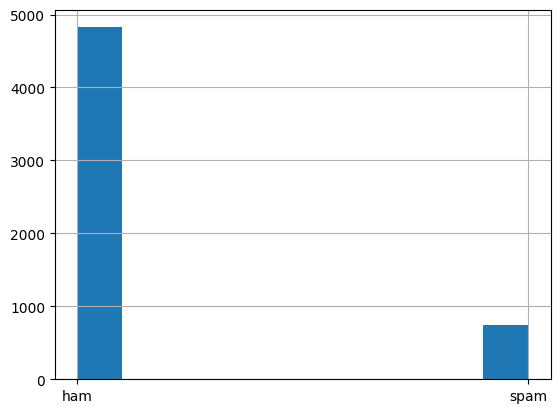

In [5]:
df['label'].hist()

map labels to integer

In [6]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [7]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


train-test split

In [8]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

Tokenize

In [9]:
max_words = 5000  # Maximum number of words to consider in our vocabulary
max_len = 100     # Maximum length of sequences. Messages longer than this will be truncated.

In [10]:
# Create and fit the tokenizer on the training texts.
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['text'])

In [12]:
# # Convert texts to sequences of integers
X_train = tokenizer.texts_to_sequences(train_data['text'])
X_test = tokenizer.texts_to_sequences(test_data['text'])

In [13]:
train_data['text'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [15]:
print(X_train[0])

[38, 30, 8, 5, 273, 1989, 81, 116, 26, 11, 1656, 322, 10, 53, 18, 299, 30, 349, 1990]


In [16]:
len(X_train[0])

19

In [17]:
# Pad sequences to ensure that all are of equal length.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [18]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   38,   30,    8,    5,  273, 1989,   81,
        116,   26,   11, 1656,  322,   10,   53,   18,  299,   30,  349,
       1990], dtype=int32)

In [19]:
len(X_train[0])

100

In [21]:
# Extract labels
y_train = train_data['label'].values
y_test = test_data['label'].values

Class weights

In [22]:
# Compute class weights to help counter the effect of imbalance
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)

In [23]:
class_weights = {i: weights[i] for i in range(len(weights))}
class_weights

{0: np.float64(0.5773316062176166), 1: np.float64(3.7328308207705194)}

Modelling & Training

In [24]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=32), # Embedding layer to learn a vector representation of words
    GlobalAveragePooling1D(), # GlobalAveragePooling layer to aggregate the word vectors and reduce dimension
    Dense(1, activation='sigmoid') # Dense layer with a sigmoid activation for binary classification
])

In [25]:
# Compile the model with the Adam optimizer and binary cross-entropy loss function.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 480,101 (1.83 MB)

 Trainable params: 160,033 (625.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,068 (1.22 MB)

In [26]:
# Train the model with 10 epochs, a validation split of 20% and class weights.
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weights)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8713 - loss: 0.6788 - val_accuracy: 0.7231 - val_loss: 0.6791
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7199 - loss: 0.6528 - val_accuracy: 0.8744 - val_loss: 0.4995
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9549 - loss: 0.5820 - val_accuracy: 0.9709 - val_loss: 0.4738
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9756 - loss: 0.5021 - val_accuracy: 0.9686 - val_loss: 0.3382
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9442 - loss: 0.4219 - val_accuracy: 0.9753 - val_loss: 0.3970
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9815 - loss: 0.3405 - val_accuracy: 0.9787 - val_loss: 0.3158
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9829 - loss: 0.2715 - val_accuracy: 0.9821 - val_loss: 0.2196
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9889 - loss: 0.2204 - val_accuracy: 0

Evaluation

In [28]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9784 - loss: 0.1386
Test Loss: 0.14582383632659912
Test Accuracy: 0.9757847785949707


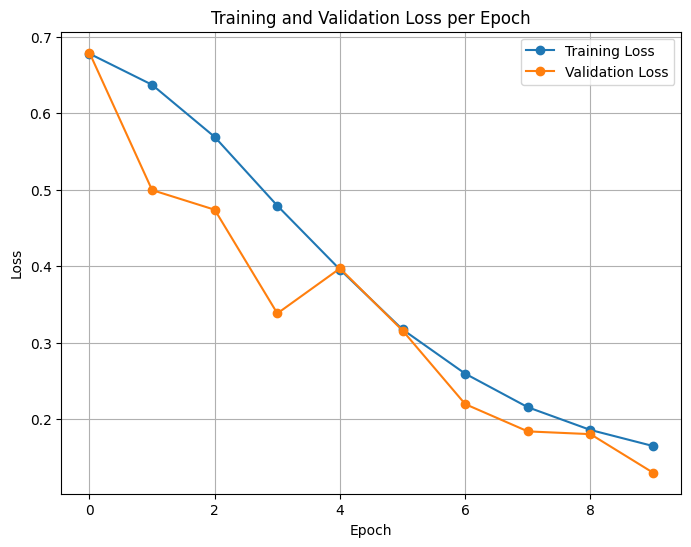

In [30]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary labels.
y_pred = (y_pred_prob > 0.5).astype(int)

f1 = f1_score(y_test, y_pred)
print("F1 Score on  X_test:", f1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1 Score on  X_test: 0.9065743944636678


In [32]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[957   8]
 [ 19 131]]
